In [909]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import matplotlib.cm as cm
from matplotlib import font_manager as fm
import numpy as np
from datetime import timedelta
from IPython.display import display

In [910]:
# Settings to use for all plots
plt.style.use('ggplot')
figsize=(12,8)

cmap = cm.get_cmap('viridis')
secs = 3600
beams = ["Low", "Medium", "High"]
tfont = fm.FontProperties(family='STIXGeneral', weight='bold', size=30)
lfont = fm.FontProperties(family='STIXGeneral', math_fontfamily="stix", size=25, weight="bold")
tick_font = fm.FontProperties(family='STIXGeneral', math_fontfamily="stix", size=20)

#### Load Data

In [911]:
data_files = []

for root, dirs, files in sorted(os.walk("./icpp_training_results")):
    if "stopping" in root:
        for i in files:
            f = os.path.join(root, i)
            data_files.append(f)

## Epoch Savings

For epoch savings, the number of GPUs should be (?) irrelevant, so we just use the different GPUs as repeated tests. It doesn't seem to be irrelevant, though. We should look into that. Is it just random? Should do more tests to find out.

In [912]:
def plot_epochs_savings(beams, num_epochs_no_stop, stop_1e14, stop_1e15, stop_1e16):
    epochs_run = {
        'Baseline': np.repeat(num_epochs_no_stop, 3),
        '1GPU with PENGUIN': (stop_1e14[0], stop_1e15[0], stop_1e16[0]),
        '4GPU with PENGUIN': (stop_1e14[1], stop_1e15[1], stop_1e16[1]),
    }

    x = np.arange(len(beams))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    # colors = cm.Blues(np.linspace(0.4, 0.9, 3))
    colors = ["xkcd:grey", "xkcd:orange", "xkcd:blue"]

    for index, (label, num_epochs) in enumerate(epochs_run.items()):
        print(label, num_epochs)
        offset = width * multiplier
        rects = ax.barh(x + offset, num_epochs, width, label=label, color=colors[index]) 
        labels = [str(round((1-(num_epochs[i]/num_epochs_no_stop))*100, 1))+'%' for i in range(len(num_epochs))]
        ax.bar_label(rects, labels=labels ,padding=2, font=tick_font)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Epochs Completed', font=lfont)
    ax.xaxis.label.set_color('black')
    ax.set_ylabel('Beam Intensity', font=lfont)
    ax.yaxis.label.set_color('black')
    ax.set_xlim(0, 2700)

    ax.set_title('Percent Epochs Saved', font=tfont)
    ax.set_yticks(x + width, beams)
    xticks = [int(x) for x in ax.get_xticks()]
    ax.set_xticklabels(xticks, color='black', font=tick_font)
    ax.set_yticklabels(beams, color='black', font=tick_font)

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2, 1, 0]

    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, -0.1),  ncol=3, prop=tick_font)

    plt.savefig('figures/epochs_saved.png')
    display(fig)
    plt.close()
    return

def calculate_and_plot_epochs_savings(files):
    no_stop_1e14, no_stop_1e15, no_stop_1e16 = [], [], []
    stop_1e14, stop_1e15, stop_1e16 = [], [], []
    stop_1e14_len, stop_1e15_len, stop_1e16_len = [], [], []
   
    for f in files: 
        if "no" in f:
            df = pd.read_csv(f)
            num_epochs_no_stopping = len(df.index) # non-stopped file

            if "1e14" in f:
                no_stop_1e14.append(df) 
            elif "1e15" in f:
                no_stop_1e15.append(df)
            elif "1e16" in f:
                no_stop_1e16.append(df)

        beam = f.split('/')[-1].split('_')[1].strip()
        gpus = f.split('/')[-1].split('_')[0].strip()
        stop = f.split('/')[-1].strip()
        if "stopping" in stop:
            df = pd.read_csv(f)
            print(f"Num epochs completed for {gpus} {beam} with PENGUIN:", len(df.index))

            if "1e14" in stop:
                stop_1e14.append(df) 
                stop_1e14_len.append(len(df.index))
            elif "1e15" in stop:
                stop_1e15.append(df) 
                stop_1e15_len.append(len(df.index))
            elif "1e16" in stop:
                stop_1e16.append(df) 
                stop_1e16_len.append(len(df.index))

    print()
    avg_epochs_completed = [sum(stop_1e14_len)/len(stop_1e14_len), sum(stop_1e15_len)/len(stop_1e15_len), sum(stop_1e16_len)/len(stop_1e16_len)]
    for i, b in enumerate(beams):
        print(f"Avg. epochs completed for {b}: {avg_epochs_completed[i]}")
        percent_epochs_saved = 1-(avg_epochs_completed[i]/num_epochs_no_stopping)
        print(f"Avg. percent epochs saved for {b}: {percent_epochs_saved*100}\n")

    plot_epochs_savings(beams, num_epochs_no_stopping, stop_1e14_len, stop_1e15_len, stop_1e16_len)

    return [no_stop_1e14, no_stop_1e15, no_stop_1e16], [stop_1e14, stop_1e15, stop_1e16]

Num epochs completed for 1gpu 1e14 with PENGUIN: 2167
Num epochs completed for 1gpu 1e15 with PENGUIN: 1647
Num epochs completed for 1gpu 1e16 with PENGUIN: 1737
Num epochs completed for 4gpu 1e16 with PENGUIN: 1639
Num epochs completed for 4gpu 1e15 with PENGUIN: 1499
Num epochs completed for 4gpu 1e14 with PENGUIN: 2101

Avg. epochs completed for Low: 2134.0
Avg. percent epochs saved for Low: 14.639999999999997

Avg. epochs completed for Medium: 1573.0
Avg. percent epochs saved for Medium: 37.08

Avg. epochs completed for High: 1688.0
Avg. percent epochs saved for High: 32.48

Baseline [2500 2500 2500]
1GPU with PENGUIN (2167, 1647, 1737)
4GPU with PENGUIN (2101, 1499, 1639)


/var/folders/8h/r7g7qn6d2jsddxt3t27653lr0000gn/T/ipykernel_4630/3939783208.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, color='black', font=tick_font)


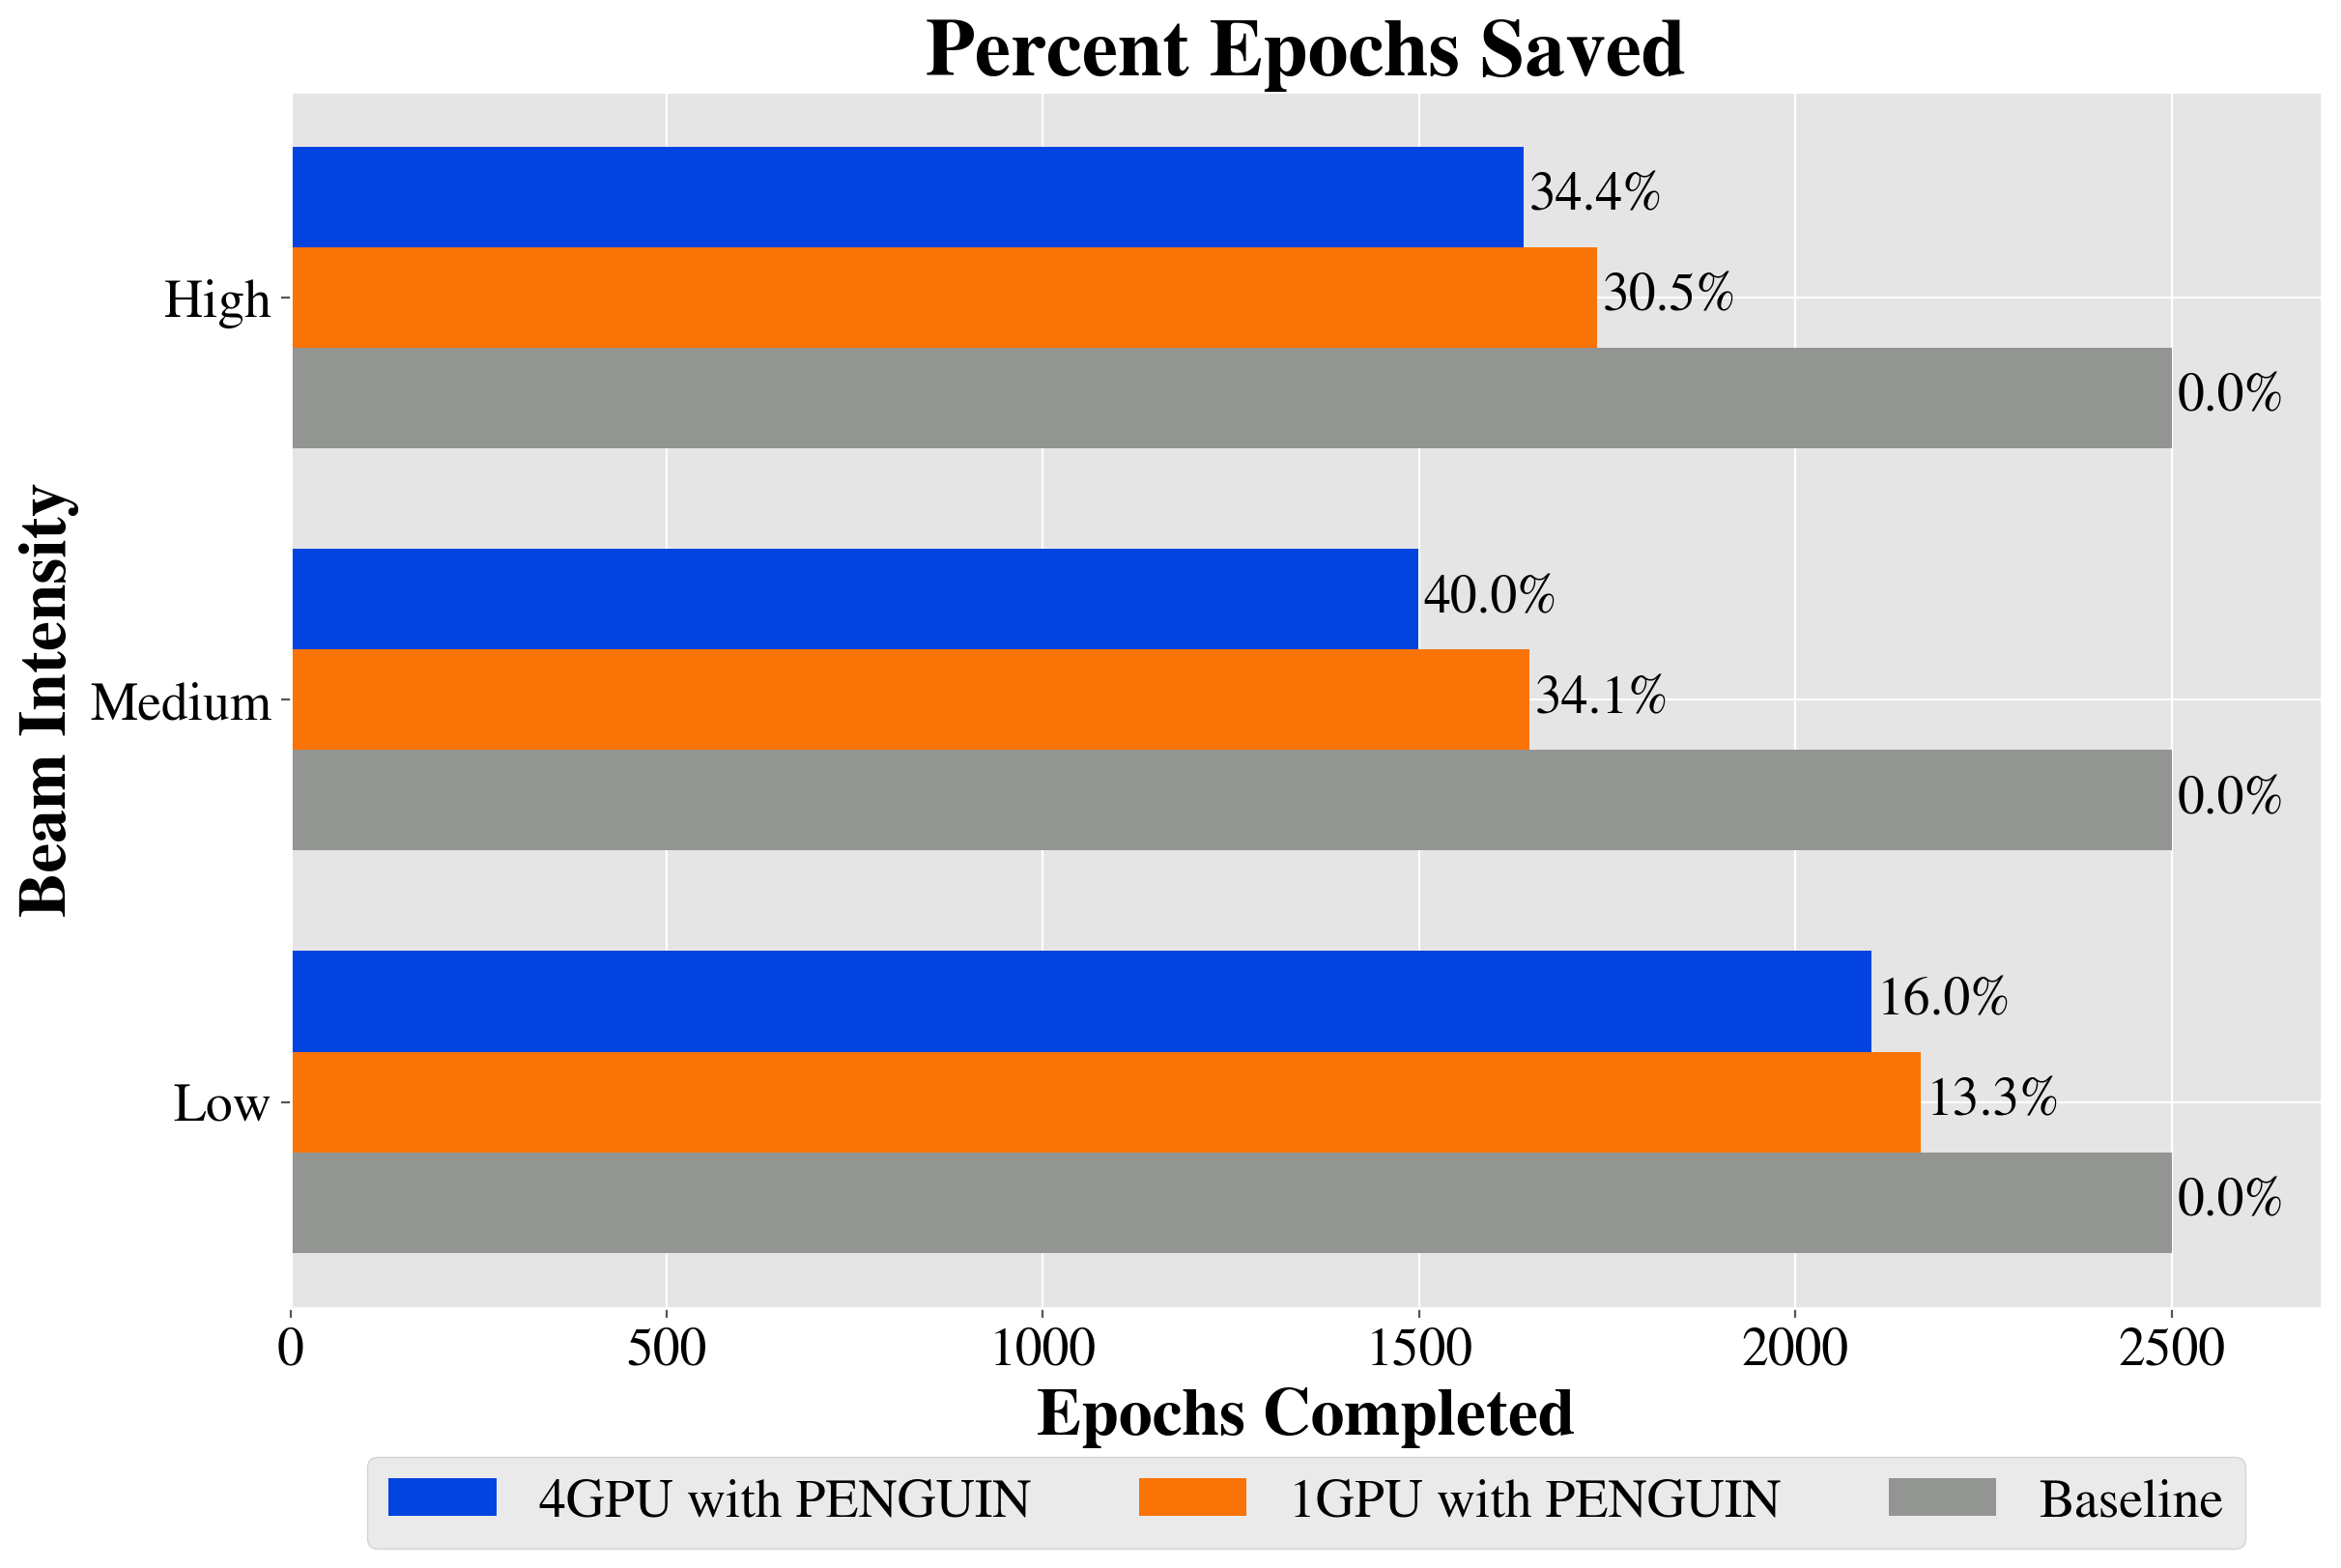

In [913]:
no_stop, stop = calculate_and_plot_epochs_savings(data_files)

## Time Savings

In [914]:
def print_wall_times(no_stop, stop):
    print("No PENGUIN:")
    for n, beam in enumerate(no_stop): # Non-stop DataFrames for 1e14, 1e15, 1e16
        for i, df in enumerate(beam):
            if i % 2 == 0: # 1 GPU
                try:
                    gpu1_time = df['epoch_times'].sum()/secs
                    print(f"1 GPU: {gpu1_time}")
                except:
                    print("Non stop 1 GPU: these runs don't have epoch times")
            else: # 4 GPU
                try:
                    gpu4_time = df['epoch_times'].sum()/secs
                    print(f"4 GPUS: {gpu4_time}")
                except:
                    print("Non stop 4 GPU: these runs don't have epoch times")
    print("\nWith PENGUIN:")
    for n, val in enumerate(stop): # Stopped DataFrames for 1e14, 1e15, 1e16
        for i, df in enumerate(val):
            if i % 2 == 0: # 1 GPU
                try:
                    gpu1_time = df['epoch_times'].sum()/secs
                    print(f"1 GPU: {gpu1_time}")
                except:
                    print("Stop 1 GPU: these runs don't have epoch times")
            else: # 4 GPU
                try:
                    gpu4_time = df['epoch_times'].sum()/secs
                    print(f"4 GPUS: {gpu4_time}")
                except:
                    print("Stop 4 GPU: these runs don't have epoch times")
    return

def get_run_time(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time

def get_run_seconds(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time.total_seconds()

def plot_times():
    time_df = pd.read_csv('./icpp_training_results/time_to_run.csv')

    # DataFrame filtering conditions
    b14, b15, b16 = (time_df['dataset']==14), (time_df['dataset']==15), (time_df['dataset']==16)
    no_stop, stop = (time_df['stopping']==False), (time_df['stopping']==True)
    gpu1, gpu4 = (time_df['gpu']==1), (time_df['gpu']==4)
    time_format = 'total_seconds'

    # Filtering data
    no_stop_1e14 = np.array([time_df[b14 & no_stop & gpu1][time_format].item(), time_df[b14 & no_stop & gpu4][time_format].item()])/secs
    no_stop_1e15 = np.array([time_df[b15 & no_stop & gpu1][time_format].item(), time_df[b15 & no_stop & gpu4][time_format].item()])/secs
    no_stop_1e16 = np.array([time_df[b16 & no_stop & gpu1][time_format].item(), time_df[b16 & no_stop & gpu4][time_format].item()])/secs

    stop_1e14 = np.array([time_df[b14 & stop & gpu1][time_format].item(), time_df[b14 & stop & gpu4][time_format].item()])/secs
    stop_1e15 = np.array([time_df[b15 & stop & gpu1][time_format].item(), time_df[b15 & stop & gpu4][time_format].item()])/secs
    stop_1e16 = np.array([time_df[b16 & stop & gpu1][time_format].item(), time_df[b16 & stop & gpu4][time_format].item()])/secs

    epochs_run = {
        '1GPU': (no_stop_1e14[0], no_stop_1e15[0], no_stop_1e16[0]),
        '1GPU + PENGUIN': (stop_1e14[0], stop_1e15[0], stop_1e16[0]),
        '4GPU': (no_stop_1e14[1], no_stop_1e15[1], no_stop_1e16[1]),
        '4GPU + PENGUIN': (stop_1e14[1], stop_1e15[1], stop_1e16[1]),
    }

    x = np.arange(len(beams))  # the label locations
    width = 0.19  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    colors = ["xkcd:pale orange", "xkcd:orange", "xkcd:sky", "xkcd:blue"]

    print()
    for index, (label, times) in enumerate(epochs_run.items()):
        print(label, times)
        offset = width * multiplier
        rects = ax.bar(x + offset, times, width, label=label, color=colors[index]) 
        labels = [round(time, 2) for time in times]
        ax.bar_label(rects, labels=labels ,padding=2, font=tick_font)
        multiplier += 1

    # Labels, title, x-axis tick labels, etc.
    ax.set_ylabel('Run Time (hours)', font=lfont)
    ax.xaxis.label.set_color('black')
    ax.set_xlabel('Beam Intensity', font=lfont)
    ax.yaxis.label.set_color('black')

    ax.set_title('Wall Hours Spent', font=tfont)
    ax.set_xticks(x + width, beams)
    ax.set_xticklabels(beams, color='black', font=tick_font)
    ax.set_yticklabels(ax.get_yticks(), color='black', font=tick_font)

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1),  ncol=4, prop=tick_font)
    display(fig)
    plt.savefig('figures/time_saved.png')
    plt.close()
    
    return

def save_and_plot_times():
    gpu=[1,1,1,1,1,1,4,4,4,4,4,4]
    stopping=[False, False, False, True, True, True, False, False, False, True, True, True]
    dataset=['14','15','16','14','15','16','14','15','16','14','15','16']
    time=['2-02_01_42','2-03_52_23','2-00_38_20','1-22_33_04','1-12_05_38','1-08_18_16','0-14_32_18','0-14_54_32','0-13_53_12','0-12_03_46','0-09_10_05','0-09_27_38']

    time_df = pd.DataFrame()
    time_df['gpu'] = gpu
    time_df['dataset'] = dataset
    time_df['stopping'] = stopping
    time_df['time'] = time
    time_df['total_time'] = time_df['time'].apply(get_run_time)
    time_df['total_seconds'] = time_df['time'].apply(get_run_seconds)

    time_df.to_csv('./icpp_training_results/time_to_run.csv', index=False)
    plot_times()
    return 

### Observe the Total GPU Wall Times

In [915]:
print_wall_times(no_stop, stop)

No PENGUIN:
Non stop 1 GPU: these runs don't have epoch times
Non stop 4 GPU: these runs don't have epoch times
Non stop 1 GPU: these runs don't have epoch times
Non stop 4 GPU: these runs don't have epoch times
Non stop 1 GPU: these runs don't have epoch times
Non stop 4 GPU: these runs don't have epoch times

With PENGUIN:
1 GPU: 46.350929785768194
4 GPUS: 40.50905620786879
1 GPU: 35.91131767789523
Stop 4 GPU: these runs don't have epoch times
1 GPU: 32.134367143445544
4 GPUS: 31.63662725733386


### Now plot all wall hours of each run


1GPU (50.028333333333336, 51.87305555555555, 48.638888888888886)
1GPU + PENGUIN (46.55111111111111, 36.09388888888889, 32.30444444444444)
4GPU (14.538333333333334, 14.908888888888889, 13.886666666666667)
4GPU + PENGUIN (12.062777777777777, 9.168055555555556, 9.460555555555555)


/var/folders/8h/r7g7qn6d2jsddxt3t27653lr0000gn/T/ipykernel_4630/3857435258.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color='black', font=tick_font)


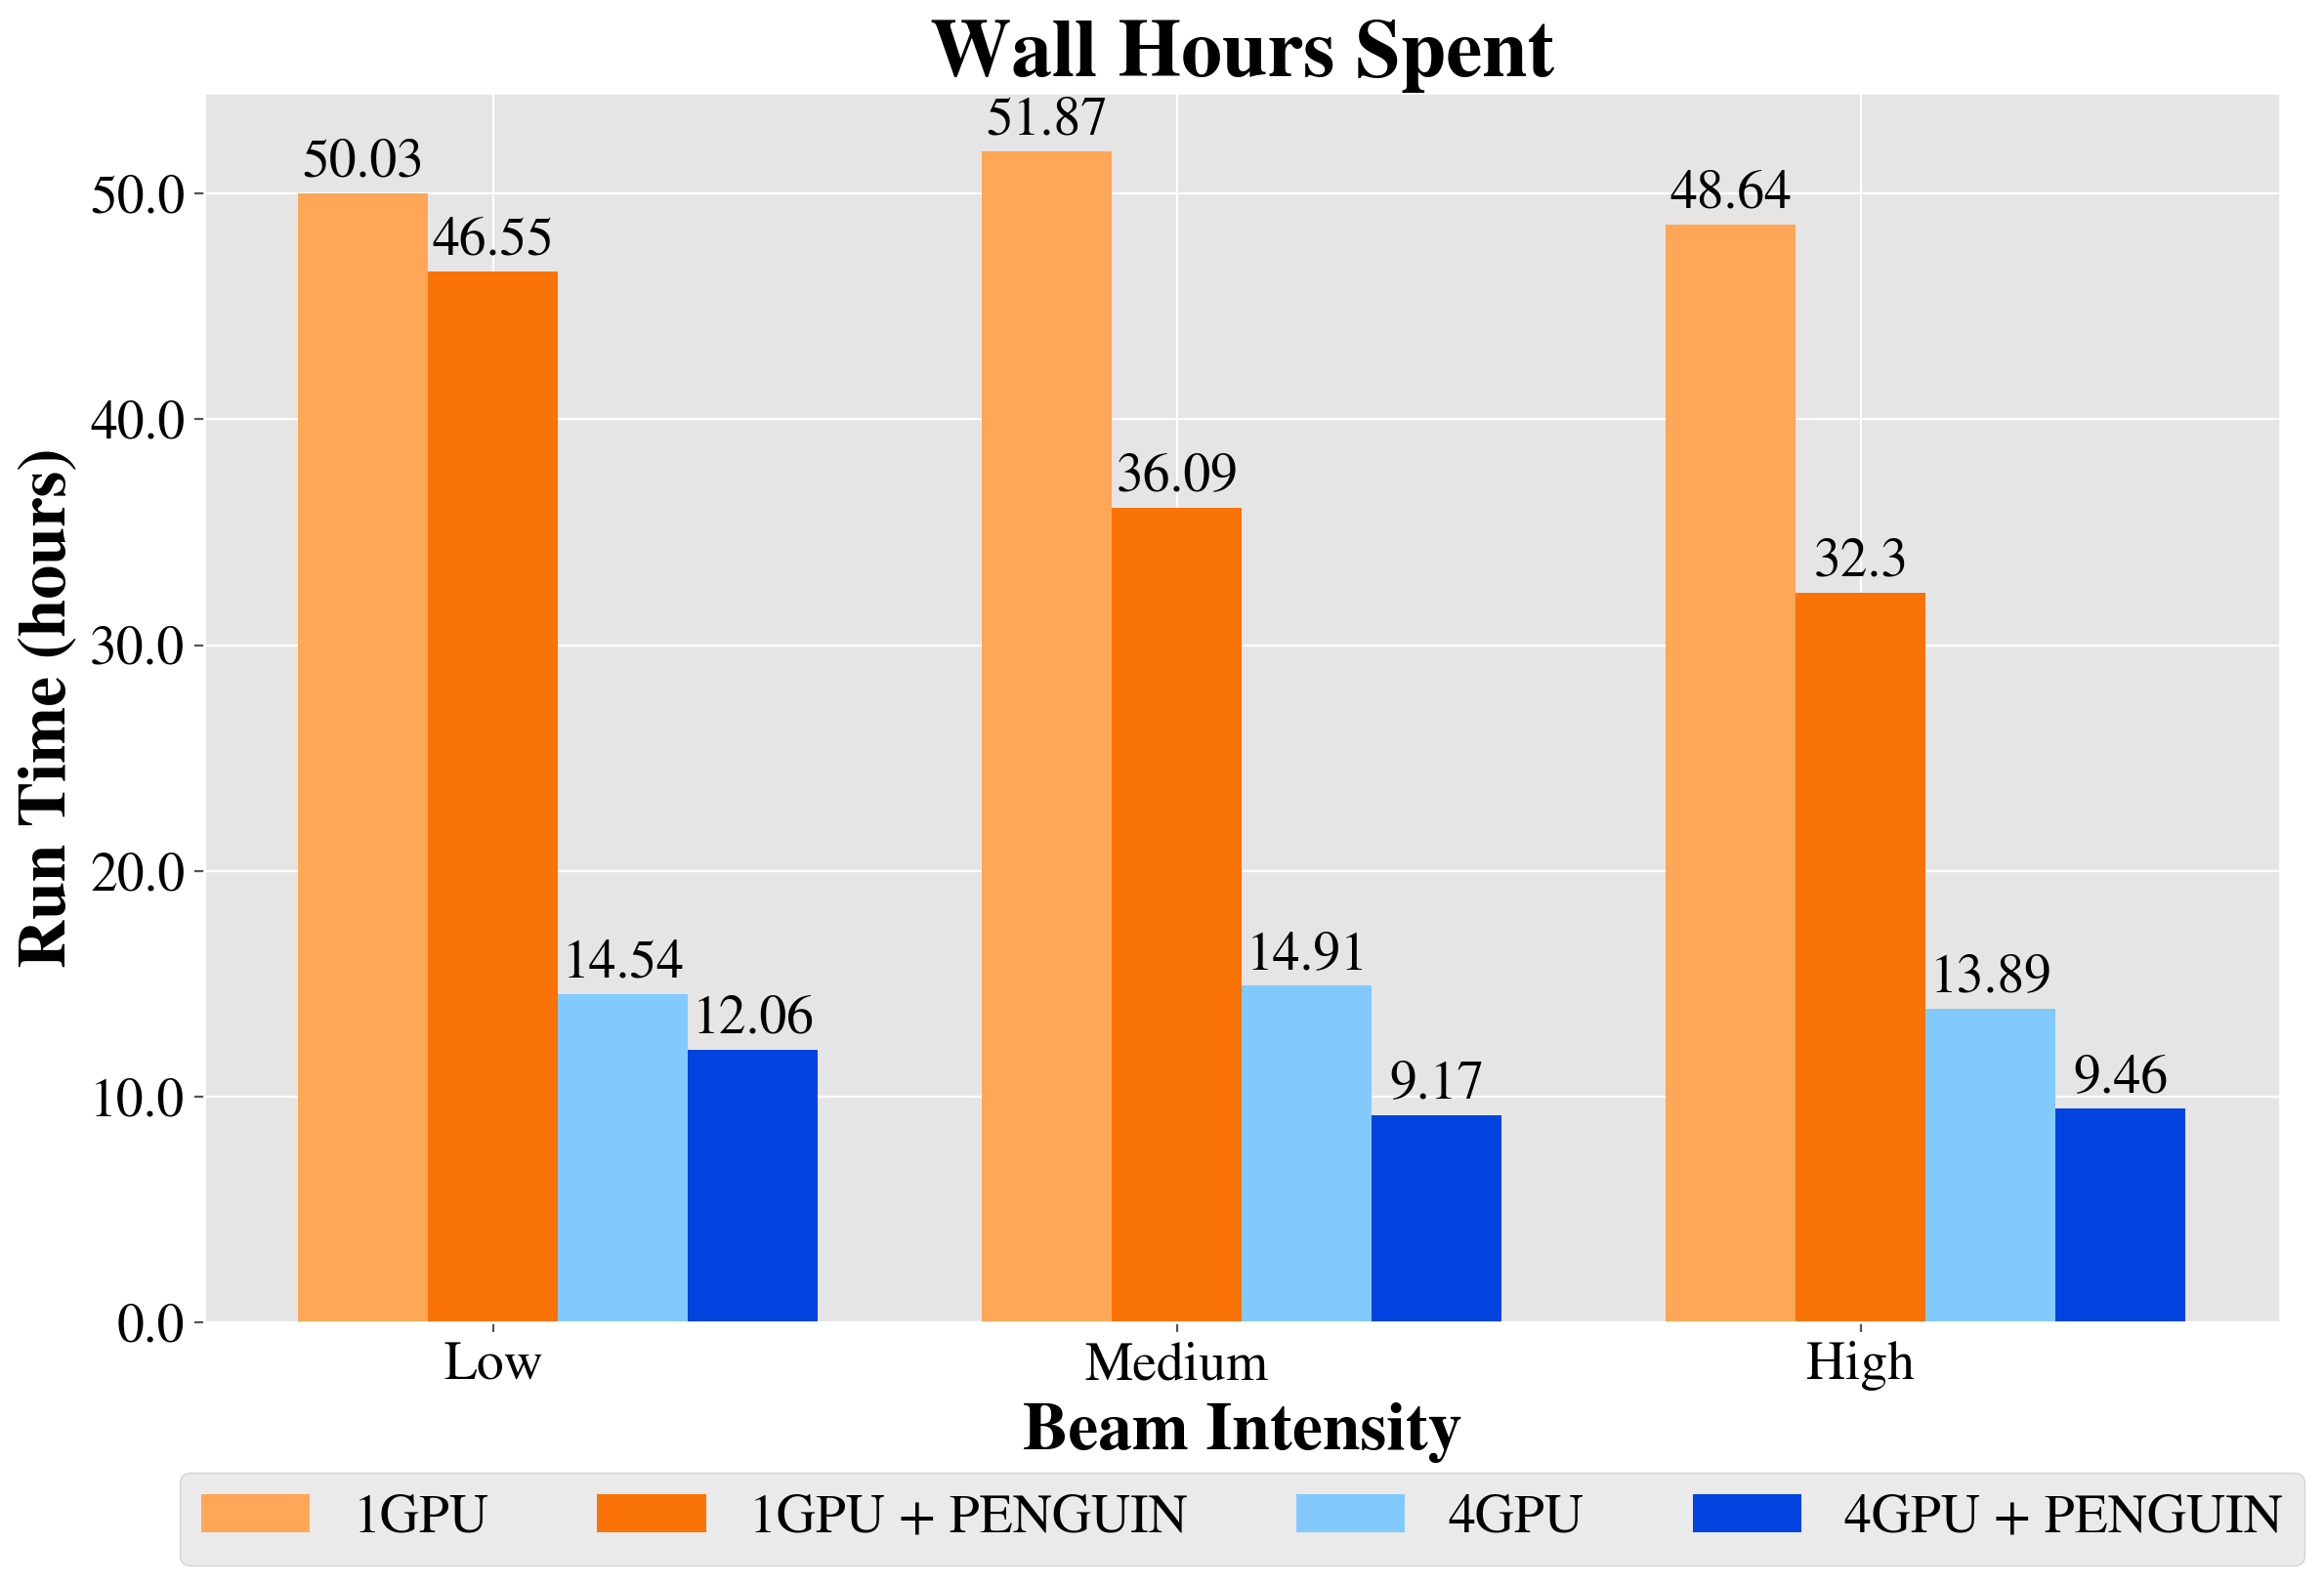

In [916]:
save_and_plot_times()

## Classification Results and Pareto Optimality

In [917]:
def one_line_per_arch_penguin(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch', ascending=False)
    if sorted_by_epoch['converged'].iloc[0] == True:
        to_return = sorted_by_epoch['predictions'].iloc[0]
        # print(to_return)
    else:
        to_return = sorted_by_epoch['val_accs'].iloc[0]
    return pd.Series({'final_acc':to_return, 'flops':arch_df['flops'].iloc[0], 'converged':sorted_by_epoch['converged'].iloc[0]})

def one_line_per_arch(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch', ascending=False)
    to_return = sorted_by_epoch['val_accs'].iloc[0]
    return pd.Series({'final_acc':to_return, 'flops':arch_df['flops'].iloc[0], 'converged':sorted_by_epoch['converged'].iloc[0]})

def is_pareto_efficient_simple(unadjusted_costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """

    # this assumes minimization, so we need to invert accuracy to make bigger, better
    # we should look more closely at this
    costs = np.zeros(unadjusted_costs.shape, dtype=float)
    costs[:,1] = unadjusted_costs[:,1]
    costs[:,0] = unadjusted_costs[:,0] * -1
    
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def make_graphic(one_line, pareto_optimals, title="FLOPS vs. Val Accuracy per Architecture", gens=10, children=10):
    fig, ax = plt.subplots(layout='constrained', figsize=(12, 8), dpi=160)

    as_numpy = one_line.to_numpy()

    plt.xlabel('FLOPS', color='black', font=lfont)
    plt.ylabel('Validation Accuracy', color='black', font=lfont)
    plt.title(title, font=tfont)
    plt.ylim(85, 100.2)

    colors = cm.viridis_r(np.linspace(0, 1, gens))
    size=100

    labels = list()
    start, end, ng = 0, 0, 0
    for g in range(0, gens * children):
        if g == 0 or g % gens == 0:
            start = g
            end = start + (children - 1)
            labels.append(f"Generation {g // gens}")
        
            ngen = as_numpy[start:end + 1]
            ax.scatter(as_numpy[start:end+1, 2], as_numpy[start:end+1, 1], color=colors[g // gens], s=size, label=f"Generation {g // gens}", zorder=3)
    
    accs = pareto_optimals['final_acc'].to_numpy()
    flops = pareto_optimals['flops'].to_numpy()
    labels.append('Pareto Optimal')
    ax.scatter(flops, accs, s=250, marker='o', color='xkcd:red', facecolor='None', linewidths=1.2, label='Pareto Optimal', zorder=10)
    ax.set_xticklabels(ax.get_xticks(), color="black", font=tick_font)
    ax.set_yticklabels(ax.get_yticks(), color="black", font=tick_font)
    plt.legend(labels, loc='lower right', prop=tick_font)

    display(fig)
    plt.savefig('figures/'+title.replace(" ", "_")+'.png')
    plt.close()
    return 


def plot_paretos(no_stop, stop):

    for n, beam in enumerate(no_stop): # Non-stop DataFrames for 1e14, 1e15, 1e16
        if n == 0: # 1e14
            tb = "Low Beam"
        elif n == 1: # 1e15
            tb = "Medium Beam"
        elif n == 2: # 1e16
            tb = "High Beam"
            
        for i, df in enumerate(beam):
            if i % 2 == 0: # 1 GPU
                title = f'1GPU with {tb} without PENGUIN'
            else:
                title = f'4GPU with {tb} without PENGUIN'

            by_arch = df.groupby('arch')
            one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
            sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
            costs = one_line[['final_acc', 'flops']].to_numpy()
            pareto_optimals = is_pareto_efficient_simple(costs)
            one_line['pareto_optimal'] = pareto_optimals
            pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
            print(f"\nParetos For {tb}:\n {pareto_optimal_arches}")
            make_graphic(one_line, pareto_optimal_arches, title=title)

    for n, beam in enumerate(stop): # Non-stop DataFrames for 1e14, 1e15, 1e16
        if n == 0: # 1e14
            tb = "Low Beam"
        elif n == 1: # 1e15
            tb = "Medium Beam"
        elif n == 2: # 1e16
            tb = "High Beam"
            
        for i, df in enumerate(beam):
            if i % 2 == 0: # 1 GPU
                title = f'1GPU with {tb} with PENGUIN'
            else:
                title = f'4GPU with {tb} with PENGUIN'

            by_arch = df.groupby('arch')
            one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
            sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
            costs = one_line[['final_acc', 'flops']].to_numpy()
            pareto_optimals = is_pareto_efficient_simple(costs)
            one_line['pareto_optimal'] = pareto_optimals
            pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
            print(f"\nParetos For {tb}:\n {pareto_optimal_arches}")
            make_graphic(one_line, pareto_optimal_arches, title=title)   
    
    return

In [918]:
# plot_paretos(no_stop, stop)

## Code for PENGUiN times and variance

print("total penguin time 1gpu 1e14:", gpu1_1e14_stopping.penguin_times.sum())
print("total penguin time 1gpu 1e15:", gpu1_1e15_stopping.penguin_times.sum())
print("total penguin time 1gpu 1e16:", gpu1_1e16_stopping.penguin_times.sum())


print("total penguin time 4gpu 1e14:", gpu4_1e14_stopping.penguin_times.sum())
#print("total penguin time 4gpu 1e15:", gpu4_1e14_stopping)
print("total penguin time 4gpu 1e16:", gpu4_1e16_stopping.penguin_times.sum())

all_penguin_times = [gpu1_1e14_stopping.penguin_times.sum(),  gpu1_1e15_stopping.penguin_times.sum(),  gpu1_1e16_stopping.penguin_times.sum(), \
     gpu4_1e14_stopping.penguin_times.sum(),  gpu4_1e16_stopping.penguin_times.sum()]

total_num_epochs_across_these_runs = len(gpu1_1e14_stopping.index) + len(gpu1_1e15_stopping.index) + \
     len(gpu1_1e16_stopping.index) + len(gpu4_1e14_stopping.index) + len(gpu4_1e16_stopping.index) 

all_individual_penguin_times = np.array(gpu1_1e14_stopping.penguin_times.to_list()+  gpu1_1e15_stopping.penguin_times.to_list() + gpu1_1e16_stopping.penguin_times.to_list() \
     + gpu4_1e14_stopping.penguin_times.to_list() +  gpu4_1e16_stopping.penguin_times.to_list())


avg_over_run = sum(all_penguin_times)/len(all_penguin_times)
avg_per_epoch = sum(all_penguin_times)/total_num_epochs_across_these_runs
res = np.var(all_individual_penguin_times)

print("Average time spent on PENGUIN over entire run:", avg_over_run)
print("Average time spent on PENGUIN per epoch:", avg_per_epoch)
print("Variance of PENGUIN length in epoch:", res)


## Code for Ariel-style Graphic

In [919]:
# stopping
gpu1_1e14_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e14_stopping_training_data.csv')
gpu1_1e15_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e15_stopping_training_data.csv')
gpu1_1e16_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e16_stopping_training_data.csv')

# no stopping
gpu1_1e14 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e14_training_data.csv')
gpu1_1e15 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e15_training_data.csv')
gpu1_1e16 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e16_training_data.csv')

# four gpu

# stopping
gpu4_1e14_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e14_stopping_training_data.csv')
gpu4_1e15_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e15_stopping_training_data.csv')
gpu4_1e16_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e16_stopping_training_data.csv')

# no stopping
gpu4_1e14 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e14_training_data.csv')
gpu4_1e15 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e15_training_data.csv')
gpu4_1e16 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e16_training_data.csv')

all_stopping = [gpu1_1e14_stopping, gpu1_1e15_stopping, gpu1_1e16_stopping, gpu4_1e14_stopping, gpu4_1e15_stopping, gpu4_1e16_stopping]

In [920]:
df = gpu1_1e15_stopping
df.head()

,epoch,train_accs,val_accs,epoch_times,predictions,converged,params,function,penguin_times,genome,architecture,flops,arch
0,0,83.647729,61.199295,200.789819,inf,False,NaN,NaN,0.000107,"[[0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0],...","[[[0], [0, 0], [0, 1, 1], [1]], [[0], [0, 0], ...",470.655,27
1,1,90.958619,50.428319,51.060312,inf,False,NaN,NaN,0.000117,"[[0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0],...","[[[0], [0, 0], [0, 1, 1], [1]], [[0], [0, 0], ...",470.655,27
2,2,92.848145,77.324263,50.881644,inf,False,NaN,NaN,0.000181,"[[0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0],...","[[[0], [0, 0], [0, 1, 1], [1]], [[0], [0, 0], ...",470.655,27
3,3,93.487435,90.287226,51.055541,182.177881,False,[199.99999998 1.08810504 59.11320681],[52.86029289 64.77435389 75.7237205 85.78650508],0.041512,"[[0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0],...","[[[0], [0, 0], [0, 1, 1], [1]], [[0], [0, 0], ...",470.655,27
4,4,94.126724,90.910809,50.878491,179.170661,False,[200. 1.08110814 63.93442647],[53.64621748 64.62613991 74.78231393 84.176539...,0.048146,"[[0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0],...","[[[0], [0, 0], [0, 1, 1], [1]], [[0], [0, 0], ...",470.655,27


In [921]:
def get_epoch_converged(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch')
    try:
        converged = sorted_by_epoch[sorted_by_epoch.converged==True].iloc[0]
        # print(converged)
        return pd.Series({'epoch_converged': converged['epoch'], 'final_fitness': sorted_by_epoch['val_accs'].iloc[-1], 'prediction':converged['predictions']})
    except:
        # print(arch_df.iloc[-1])
        return pd.Series({'epoch_converged': np.inf, 'final_fitness': sorted_by_epoch['val_accs'].iloc[-1], 'prediction':None})

by_arch = df.groupby('arch')
where_converged = by_arch.apply(get_epoch_converged).reset_index()  

In [922]:
percent_converged = len(where_converged[where_converged.epoch_converged!=np.inf].index) / len(where_converged.index) * 100
print("Percent Converged is: ", percent_converged)

mean = where_converged[where_converged.epoch_converged!=np.inf].epoch_converged.mean()
print("Avg epoch converged (for those converged) is: ", mean)

print("converged arches and their earliest convergence:")
only_converged_arches = pd.DataFrame(where_converged.loc[where_converged.epoch_converged!=np.inf,:])
only_converged_arches.head()

Percent Converged is:  69.0
Avg epoch converged (for those converged) is:  11.63768115942029
converged arches and their earliest convergence:


,arch,epoch_converged,final_fitness,prediction
0,0,5.0,93.020912,92.622012
2,2,8.0,98.412698,97.846239
3,3,8.0,97.549761,96.689185
5,5,8.0,98.305619,98.925455
7,7,13.0,95.956160,95.899747


## Violin Plot of Convergence

percent converged is: 61.0
percent converged is: 69.0
percent converged is: 56.00000000000001
percent converged is: 67.0
percent converged is: 80.0
percent converged is: 57.99999999999999


/var/folders/8h/r7g7qn6d2jsddxt3t27653lr0000gn/T/ipykernel_4630/1860737614.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Low Beam\n1 GPU', 'Medium Beam\n1 GPU', 'High Beam\n1 GPU', 'Low Beam\n4 GPU', 'Medium Beam\n4 GPU', 'High Beam\n4 GPU'], font=tick_font)


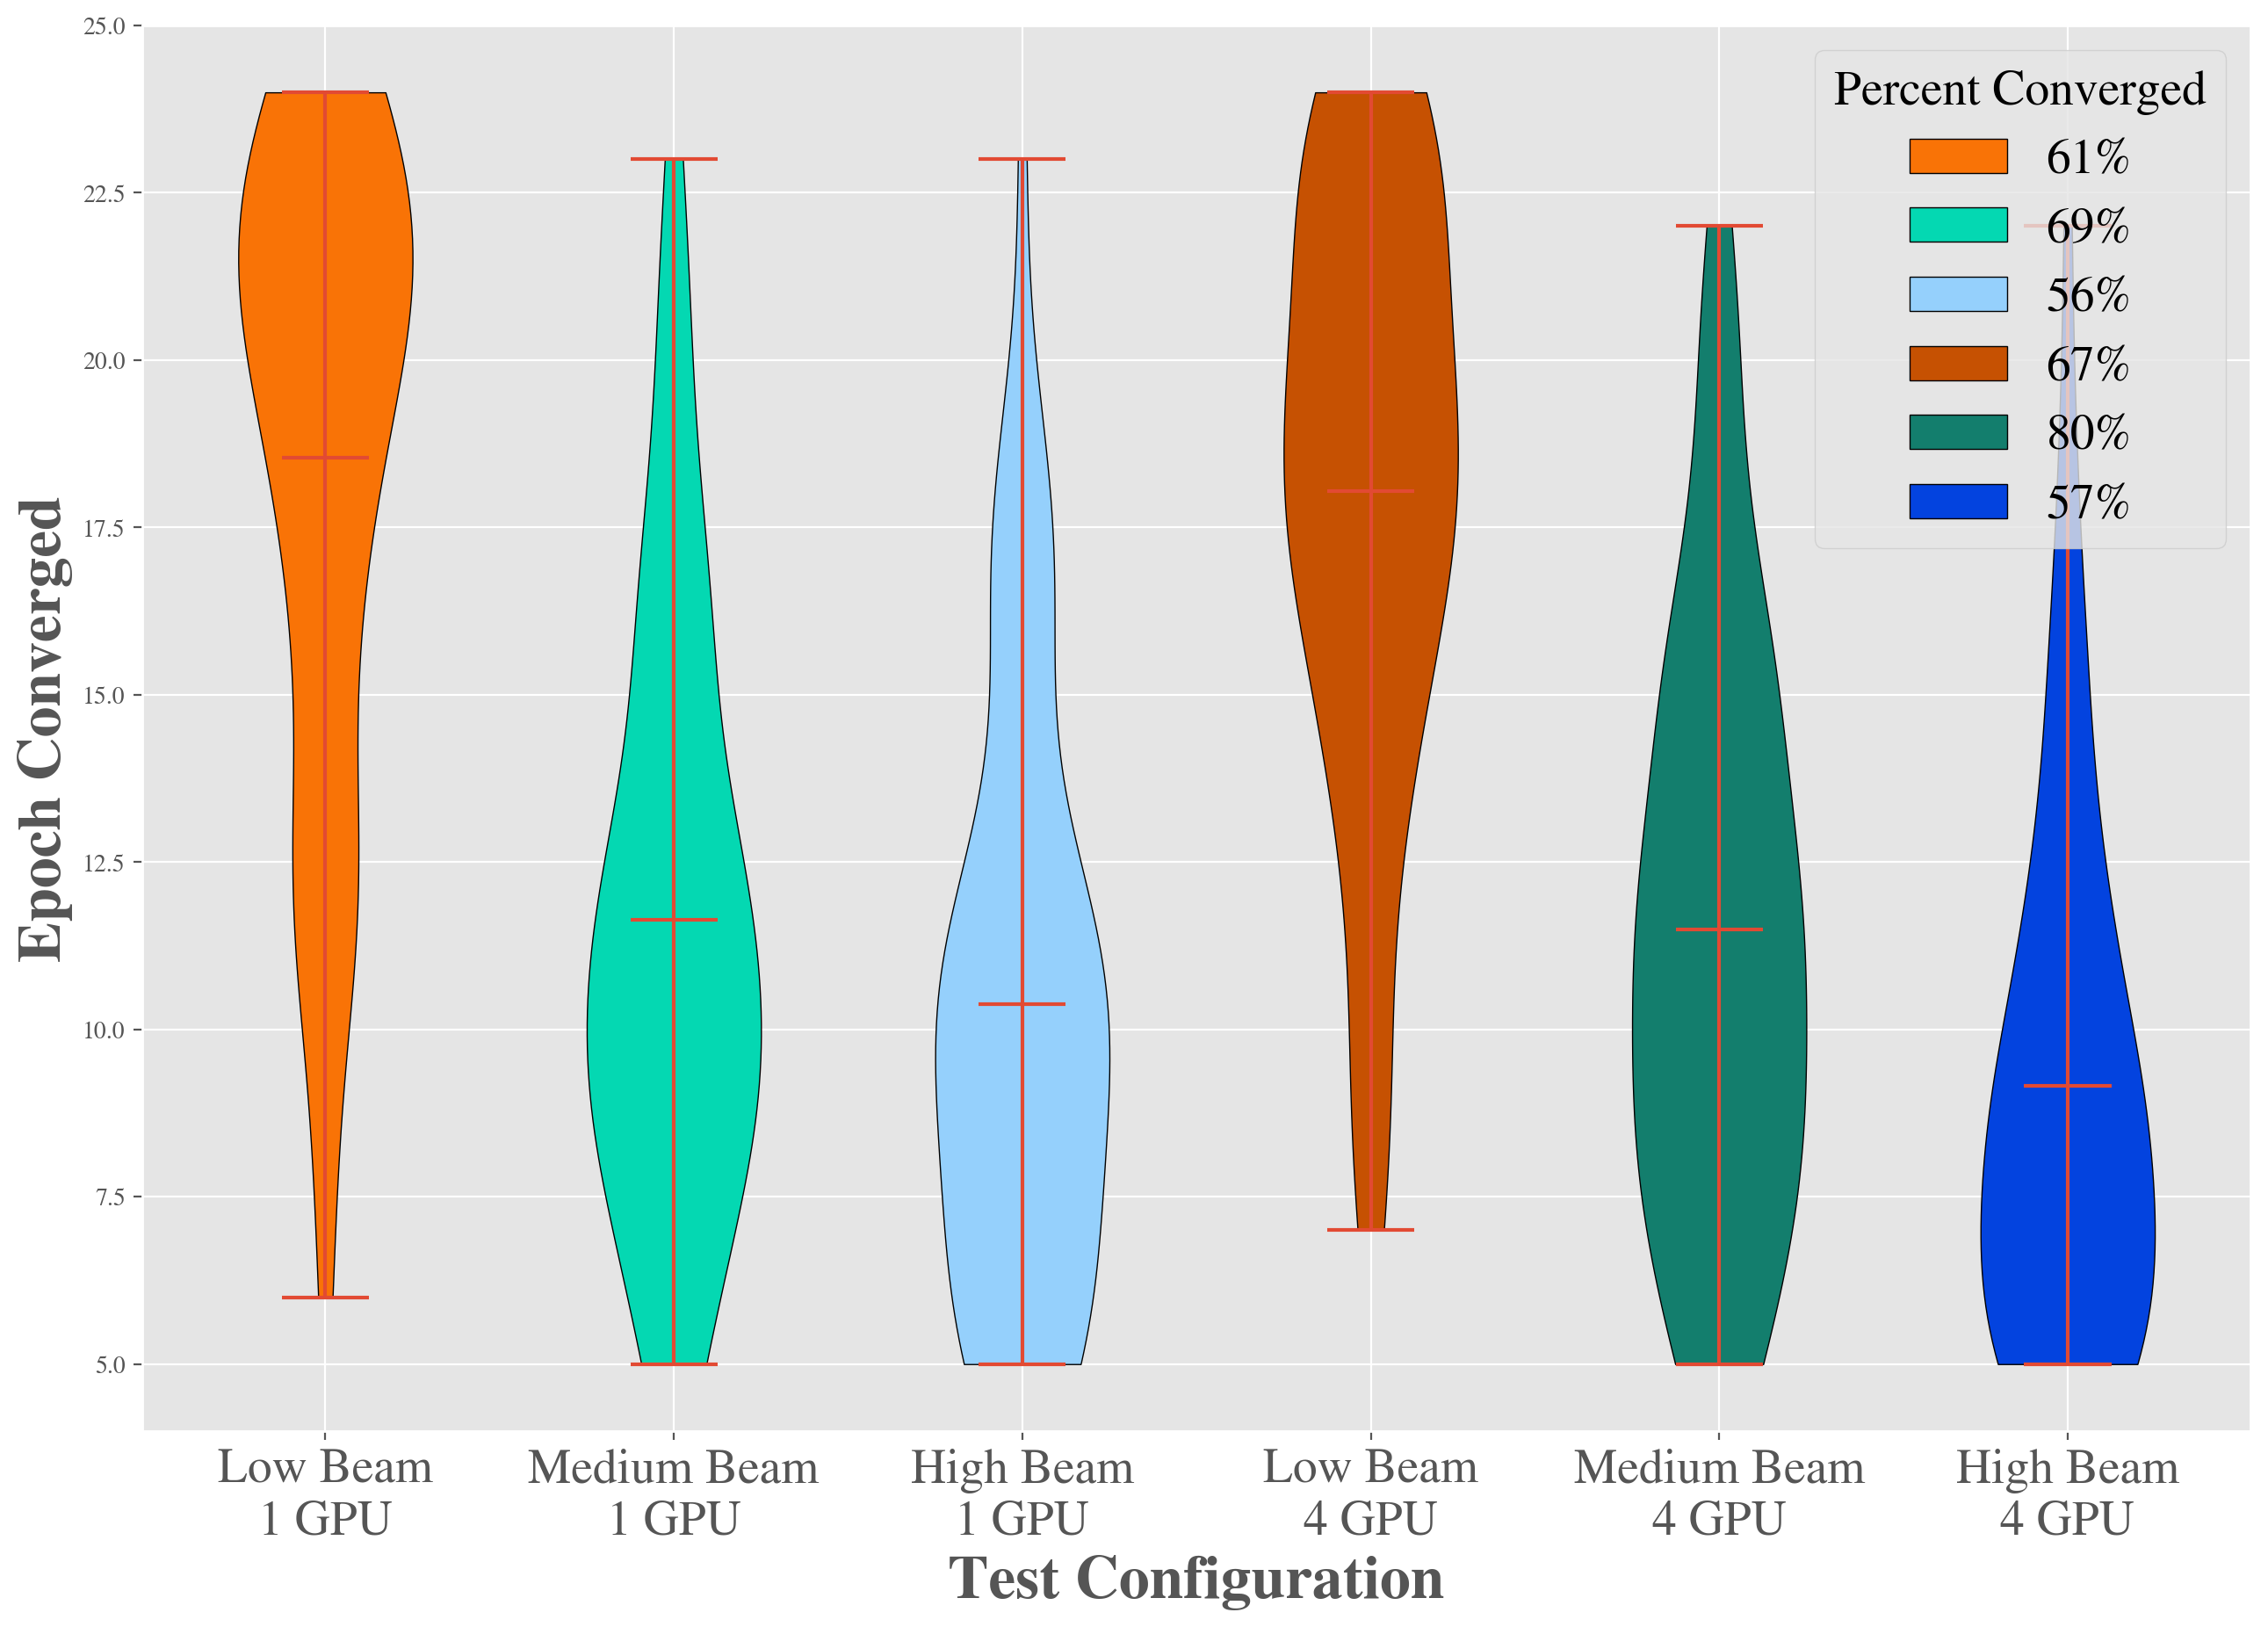

In [954]:


figsize=(12,8)

sets = list()
percents = list()

for df in all_stopping:
    by_arch = df.groupby('arch')
    where_converged = by_arch.apply(get_epoch_converged).reset_index()
    only_converged_arches = pd.DataFrame(where_converged.loc[where_converged.epoch_converged!=np.inf,:])
    sets.append(only_converged_arches.epoch_converged.to_list())
    

    percent_converged = len(where_converged[where_converged.epoch_converged!=np.inf].index) / len(where_converged.index) * 100
    percents.append(percent_converged)
    print("percent converged is:", percent_converged)

data_to_plot = sets
fig, ax = plt.subplots(layout='constrained', figsize=figsize)

ax = fig.add_axes([0,0,1,1])

ax.set_ylim(4, 25)
ax.set_xticklabels(['', 'Low Beam\n1 GPU', 'Medium Beam\n1 GPU', 'High Beam\n1 GPU', 'Low Beam\n4 GPU', 'Medium Beam\n4 GPU', 'High Beam\n4 GPU'], font=tick_font)
ax.set_xlabel('Test Configuration', font=lfont)
ax.set_ylabel('Epoch Converged', font=lfont)

bp = ax.violinplot(data_to_plot, showmeans=True)
colors=["xkcd:orange", "xkcd:aquamarine", "xkcd:light blue", "xkcd:dark orange", "xkcd:blue green", "xkcd:blue"]

for pc, color, percent in zip(bp['bodies'], colors, percents):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_label(str(int(percent))+'%')
    pc.set_alpha(1)

plt.legend(title="Percent Converged", prop=tick_font, title_fontproperties=tick_font)
plt.savefig('figures/violin_converged.png')
plt.show()


## We use arch 38 from 1e15 to make Ariel-graphic

In [903]:
arch_44 = df[df['arch']==38]
print(arch_44)

    epoch  train_accs    val_accs  epoch_times  predictions  converged  \
18      0   94.076337   96.453767    87.673224          inf      False   
19      1   99.015872   96.088435    72.857168          inf      False   
20      2   99.426844   99.905518    72.986744          inf      False   
21      3   99.777981   98.708743    72.772625   102.871466      False   
22      4   99.785854   99.061476    72.955597   100.034622      False   
23      5   99.943314   99.722852    72.879689   100.217410      False   
24      6   99.960635   98.337113    72.862978    99.275405      False   
25      7   99.842540  100.000000    72.863364    99.561043      False   
26      8   99.998425  100.000000    72.881761    99.749493       True   

    penguin_times                                             genome  \
18       0.000142  [[1, 0, 1, 1, 0, 1, 0], [1, 1, 0, 0, 0, 0, 1],...   
19       0.000134  [[1, 0, 1, 1, 0, 1, 0], [1, 1, 0, 0, 0, 0, 1],...   
20       0.000118  [[1, 0, 1, 1, 0, 1, 0], 

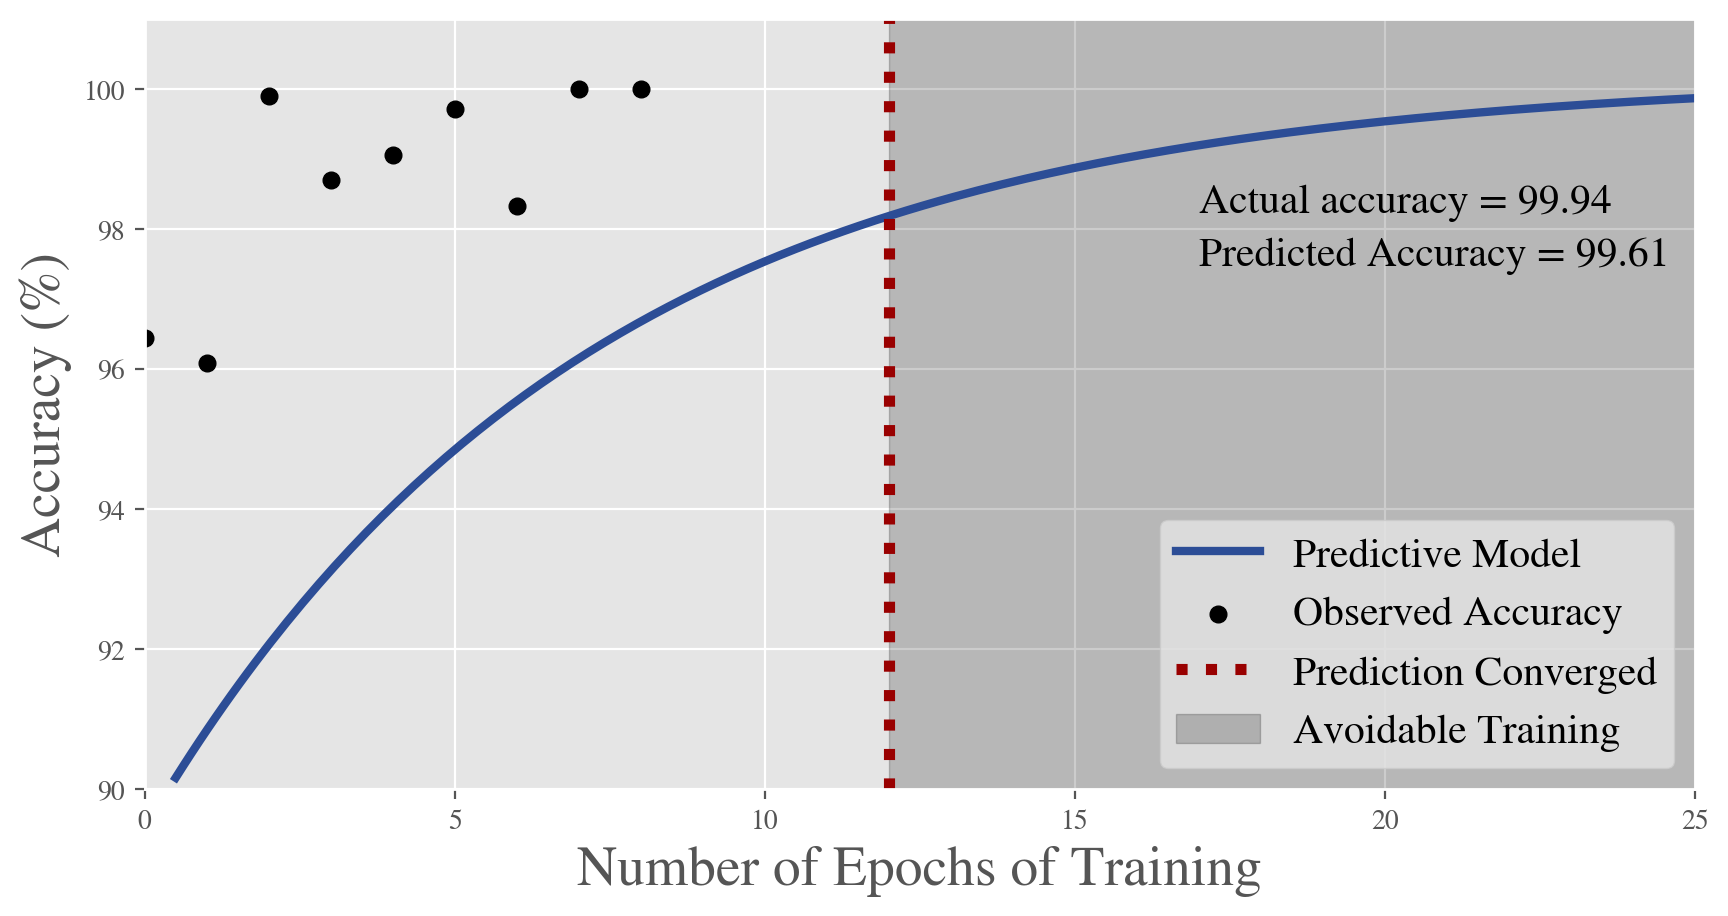

In [904]:


plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200

a = 100.2
b = 1.15
c = 17

x = np.linspace(0.5,26,200)
y=a-b**(c-x)

epochs, fitness = arch_44['epoch'].to_list(), arch_44['val_accs'].to_list()
prediction = 99.614529
actual = 99.943311

plt.plot(x,y,color="#2C4D96",label="Predictive Model", linewidth=3)

plt.scatter(epochs, fitness, c='black', marker='o', facecolor='None', label='Observed Accuracy')
plt.vlines(12,90,101,colors='#990000',linestyles=":",linewidth=4, label="Prediction Converged")
plt.axvspan(12, 26, color = 'k', alpha = 0.2, label="Avoidable Training")

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(0.52,0.06),labelspacing=0.4,fontsize=15)
plt.annotate('Predicted Accuracy = {:.2f}'.format(prediction), xy=(0.68, 0.68), xycoords='axes fraction', fontsize=15)
plt.annotate('Actual accuracy = {:.2f}'.format(actual), xy=(0.68, 0.75), xycoords='axes fraction', fontsize=15)

plt.ylim(90, 101)
plt.xlim(0, 25)

plt.ylabel("Accuracy (%)", fontsize=20)
plt.xlabel("Number of Epochs of Training", fontsize=20)
plt.legend(loc='lower right', fontsize=15)

plt.savefig('figures/penguin_example.png')
plt.show()
